# Top Lane Champion Performance and Meta Analysis in League of Legends: A Comprehensive Analysis of Performance and Win Rates (with Tiers)

# Objective
- Evaluate champion performance across 100 top-ranked matches 
    - Gather data on champion win rates, pick rates, and other performance metrics using the RIOT API.
- Analyze
    - Assess how top lane champions perform in the current meta.
- Visualize
    - Create visualizations that highlight which champions are overperformaning and those who are underperforming.
- Outcome
    - Provide data-driven recommendations for balancing champions and informing patch decisions.

#### Tools and Technologies
- Programming Language: Python
- Data Collection: League of Legends API (Riot Games API)
- Data Storage: CSV files
- Data Analysis: Pandas, NumPy, Scikit-learn, Statsmodels
- Visualization: Matplotlib, Seaborn, Plotly

# 0. Import necessary packages

In [2]:
import json
import re
import numpy as np
import pandas as pd
import requests
import time
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## 0.1 Define constants

In [90]:
# Load config file
with open('config.json', 'r') as file:
    config = json.load(file)

# Access API_KEY, CREDENTIALS and constants
API_KEY = config.get("API_KEY")
CREDENTIALS = config.get("CREDENTIALS")
REGION = 'na1'
TOP_N = 100
TIER_COLORS = {
        'S-Tier': '#FF5733',  # Red
        'A-Tier': '#FFC300',  # Yellow
        'B-Tier': '#DAF7A6',  # Light Green
        'C-Tier': '#28B463',  # Green
        'D-Tier': '#1F618D'   # Blue
    }

<br>

# 1. Data collection

## 1.1 API handling

In [3]:
def make_request(url):
    headers = {
        "X-Riot-Token": API_KEY
    }
    while True:
        response = requests.get(url, headers=headers)
        if response.status_code == 429:  # Rate limit exceeded
            retry_after = int(response.headers.get('Retry-After', 1))
            print(f"Rate limit exceeded. Retrying after {retry_after} seconds...")
            time.sleep(retry_after)
        elif response.status_code == 200:
            return response.json()
        else:
            print(f"Request failed with status code {response.status_code}")
            response.raise_for_status()

## 1.2 Connect to database

In [4]:
# PostgreSQL connection
DATABASE_URL = CREDENTIALS

## 1.3 Get top summoners

In [5]:
def get_challenger_summoner_ids():
    url = f'https://{REGION}.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key={API_KEY}'
    challenger_data = make_request(url)
    summoner_ids = [entry['summonerId'] for entry in challenger_data['entries']]
    return summoner_ids

## 1.4 Get summoner puuid

In [6]:
def get_puuid_by_summoner_id(summoner_id):
    url = f'https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={API_KEY}'
    summoner_data = make_request(url)
    return summoner_data['puuid']

## 1.5 Get match ids

In [7]:
def get_match_ids_by_puuid(puuid, count=40):
    url = f'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count={count}&api_key={API_KEY}'
    match_ids = make_request(url)
    return match_ids

## 1.6 Get match data

In [8]:
def get_match_data(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={API_KEY}"
    match_data = make_request(url)
    return match_data

## 1.7 Collect all data

In [9]:
def collect_data():
    # Step 1: Get top Challenger Summoner IDs
    summoner_ids = get_challenger_summoner_ids()
    
    # Step 2: Get PUUIDs for each Summoner ID
    puuids = [get_puuid_by_summoner_id(summoner_id) for summoner_id in summoner_ids]

    # Step 3: Get Match IDs for each PUUID and collect match data
    match_ids = []
    match_data_list = []
    for puuid in puuids:
        match_ids.extend(get_match_ids_by_puuid(puuid, count=40))

    # Ensure unique match IDs
    unique_match_ids = list(set(match_ids))[:400]

    # Step 4: Fetch match data for each match ID
    for match_id in unique_match_ids:
        match_data = get_match_data(match_id)
        match_data_list.append(match_data)

    # Step 5: Convert match data to DataFrame
    match_data_df = pd.json_normalize(match_data_list)

    # Step 6: Save match data to CSV
    match_data_df.to_csv('ranked_match_data.csv', index=False)
    print("Data collection complete. Match data saved to 'ranked_match_data.csv'.")

In [ ]:
# Run the data collection process
# collect_data()

In [3]:
df = pd.read_csv('ranked_match_data.csv')

## 1.5 Extract participant info

In [4]:
# Flatten the participants data
participants_df = pd.json_normalize(df['info.participants'].apply(eval).explode())

In [5]:
# View the dataframe
participants_df.head()

,allInPings,assistMePings,assists,baronKills,basicPings,bountyLevel,champExperience,champLevel,championId,championName,...,challenges.junglerKillsEarlyJungle,challenges.killsOnLanersEarlyJungleAsJungler,challenges.teleportTakedowns,challenges.highestCrowdControlScore,challenges.highestWardKills,challenges.fastestLegendary,challenges.fasterSupportQuestCompletion,challenges.baronBuffGoldAdvantageOverThreshold,challenges.thirdInhibitorDestroyedTime,challenges.hadAfkTeammate
0,0,5,15,0,0,0,23981,18,68,Rumble,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,16,8,1,0,0,26969,18,245,Ekko,...,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,1,8,0,0,0,20720,18,58,Renekton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,9,12,1,0,0,20096,18,119,Draven,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,13,0,0,0,14609,15,89,Leona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Create a list of columns
participants_df_cols = participants_df.columns

# Print out all of the columns
for col in participants_df_cols:
    print(col)

allInPings
assistMePings
assists
baronKills
basicPings
bountyLevel
champExperience
champLevel
championId
championName
championTransform
commandPings
consumablesPurchased
damageDealtToBuildings
damageDealtToObjectives
damageDealtToTurrets
damageSelfMitigated
dangerPings
deaths
detectorWardsPlaced
doubleKills
dragonKills
eligibleForProgression
enemyMissingPings
enemyVisionPings
firstBloodAssist
firstBloodKill
firstTowerAssist
firstTowerKill
gameEndedInEarlySurrender
gameEndedInSurrender
getBackPings
goldEarned
goldSpent
holdPings
individualPosition
inhibitorKills
inhibitorTakedowns
inhibitorsLost
item0
item1
item2
item3
item4
item5
item6
itemsPurchased
killingSprees
kills
lane
largestCriticalStrike
largestKillingSpree
largestMultiKill
longestTimeSpentLiving
magicDamageDealt
magicDamageDealtToChampions
magicDamageTaken
needVisionPings
neutralMinionsKilled
nexusKills
nexusLost
nexusTakedowns
objectivesStolen
objectivesStolenAssists
onMyWayPings
participantId
pentaKills
physicalDamageDealt


In [7]:
# Function that extracts columns with specific prefixes and saves them to a csv
def extract_feature_columns(df):   
    # Define which features should be extraced
    columns_to_extract = ['challenges', 'missions', 'perks']
    
    # Initialize a list to store the columns that will be excluded from participants dataframe
    columns_to_exclude = []
    
    for feature in columns_to_extract:
        # Extract columns that start with the feature
        feature_columns = [col for col in df.columns if col.startswith(feature)]
        
        # Add these columns to the list of columns to exclude later
        columns_to_exclude.extend(feature_columns)
    
        # Create a new DataFrame with only the feature columns
        features_data = df[feature_columns]
        
        # Rename columns by removing the feature prefix
        features_data = features_data.rename(columns=lambda x: x.replace(f"{feature}.", ''))
                                             
        # Set the index name to 'participant_id'
        features_data.index.name = 'participant_id'
        
        # Save processed data to a csv
        features_data.to_csv(f'{feature}.csv', index=True)
        
    # Create the participants DataFrame by excluding the feature columns
    participants_df = df.drop(columns=columns_to_exclude, axis=1)
    
    # Set the index name to 'participant_id' for consistency
    participants_df.index.name = 'participant_id'
    
    # Save the participants data to a CSV
    participants_df.to_csv('participants.csv', index=True)

In [8]:
extract_feature_columns(participants_df)

In [9]:
df = pd.read_csv('participants.csv')

# Set the option to display all columns
pd.set_option('display.max_columns', None)

## 1.6 Filter for Top laners

In [10]:
role_columns = [col for col in df.columns if 'role' in col.lower() or 'position' in col.lower()]
role_columns

['individualPosition', 'role', 'teamPosition']

In [11]:
# Filter the dataset for champions in the top role
df = df[
    (df['individualPosition'].str.lower() == 'top') | 
    (df['role'].str.lower() == 'top') | 
    (df['teamPosition'].str.lower() == 'top')
]

## 1.7 Determine key features

In [12]:
# Convert all boolean columns to int for analysis
df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)

In [13]:
# Separate the features and target variable
object_cols = list(df.select_dtypes(include=['object']).columns)

# Append the 'win' column to the list
object_cols.append('win')

X = df.drop(columns=object_cols)
y = df['win'].astype(int)  # Converting True/False to 1/0

In [14]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Training a Random Forest classifier to determine feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Making predictions and evaluating the model
y_pred = rf.predict(X_test)
accuracy = (round(accuracy_score(y_test, y_pred), 2) * 100)

In [17]:
# Extracting feature importances
feature_importances = rf.feature_importances_
important_features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
important_features = important_features.sort_values(by='Importance', ascending=False).head(30)

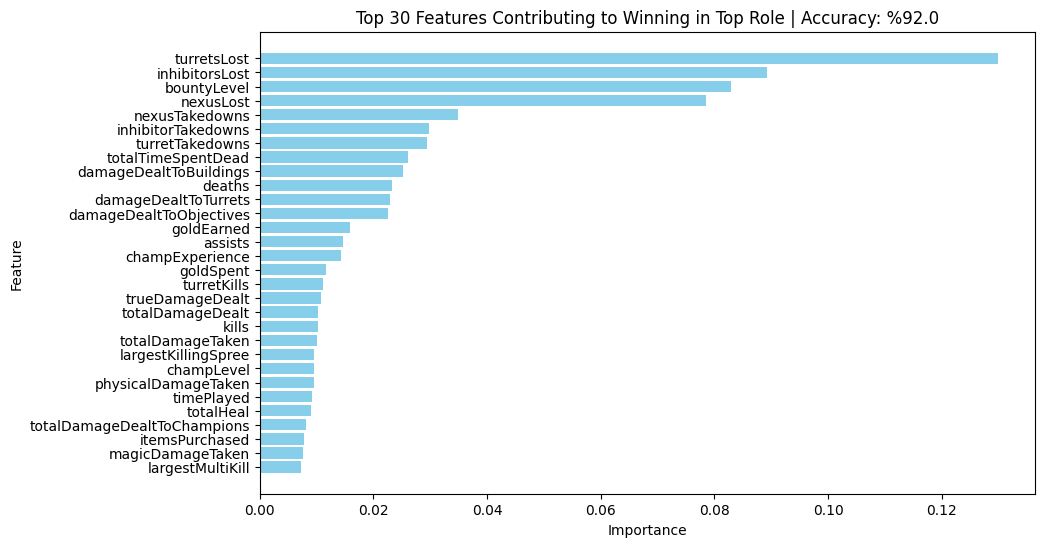

In [18]:
# Visualizing the top features
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top 30 Features Contributing to Winning in Top Role | Accuracy: %{accuracy}')
plt.gca().invert_yaxis()  # To have the most important feature on top
plt.show()

Interpretations:
- Due to top lane champions playing such a significant role in controlling objectives and, in turn, contributing to such a high level of the general success factor of a team, I will keep the objective-based features. 
- Alternatively, analysis on strictly champion performance features such as kills, assists, deaths, etc. could also be considered when determine a champion meta.
- For this analysis, I'll focus the top 15 features that includes a mix of champion-specific features such as assists and deaths, as well as team-oriented metrics.

## 1.8 Filter for important features

In [19]:
# Create a list of features that includes the top 15 most important features to winning
features_list = important_features.sort_values('Importance', ascending=False).head(15)['Feature'].tolist()

# Add additional features
features_list.extend(['win', 'championName'])

# Filter dataframe with updated features
df = df[features_list]

## 1.9 Rename features

In [20]:
# Function to convert to snake case
def to_snake_case(column_name):
    # Replace any uppercase letter with _lowercase
    return re.sub(r'(?<!^)(?=[A-Z])', '_', column_name).lower()

# Apply the function to all columns
snake_case_columns = [to_snake_case(col) for col in df.columns]

# Update dataframe columns with new column names
df.columns = snake_case_columns

# Save dataframe to csv
df.to_csv('top_lane_champions_importance.csv', index=False)

<br>

# 2. Exploratory data analysis

## 2.1 Quick glance at the data

In [21]:
df = pd.read_csv('top_lane_champions_importance.csv')

# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [22]:
df.head()

,turrets_lost,inhibitors_lost,bounty_level,nexus_lost,nexus_takedowns,inhibitor_takedowns,turret_takedowns,total_time_spent_dead,damage_dealt_to_buildings,deaths,damage_dealt_to_turrets,damage_dealt_to_objectives,gold_earned,assists,champ_experience,win,champion_name
0,7,2,0,1,0,1,5,411,5028,10,5028,12059,18630,15,23981,0,Rumble
1,10,3,0,0,1,2,5,411,3043,9,3043,4980,15838,23,22715,1,Aurora
2,0,0,0,0,0,0,0,28,0,2,0,573,4871,2,7544,0,Garen
3,0,0,4,0,0,0,0,10,1302,1,1302,1302,6649,3,9275,1,Urgot
4,2,0,0,0,0,1,3,295,7920,8,7920,8495,14913,4,17413,1,Teemo


In [23]:
df.shape

(570, 17)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   turrets_lost                570 non-null    int64 
 1   inhibitors_lost             570 non-null    int64 
 2   bounty_level                570 non-null    int64 
 3   nexus_lost                  570 non-null    int64 
 4   nexus_takedowns             570 non-null    int64 
 5   inhibitor_takedowns         570 non-null    int64 
 6   turret_takedowns            570 non-null    int64 
 7   total_time_spent_dead       570 non-null    int64 
 8   damage_dealt_to_buildings   570 non-null    int64 
 9   deaths                      570 non-null    int64 
 10  damage_dealt_to_turrets     570 non-null    int64 
 11  damage_dealt_to_objectives  570 non-null    int64 
 12  gold_earned                 570 non-null    int64 
 13  assists                     570 non-null    int64 

In [25]:
df.describe()

,turrets_lost,inhibitors_lost,bounty_level,nexus_lost,nexus_takedowns,inhibitor_takedowns,turret_takedowns,total_time_spent_dead,damage_dealt_to_buildings,deaths,damage_dealt_to_turrets,damage_dealt_to_objectives,gold_earned,assists,champ_experience,win
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000
mean,5.191228,0.722807,0.938596,0.326316,0.240351,0.403509,2.238596,155.707018,4956.482456,5.192982,4956.482456,7718.487719,10888.991228,5.005263,13538.492982,0.500000
std,3.617997,1.013272,1.786913,0.469276,0.427672,0.695445,2.087519,98.236615,4362.515845,2.875499,4362.515845,6793.835767,3646.129664,3.886117,4214.795052,0.500439
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,83.250000,1665.750000,3.000000,1665.750000,2414.750000,8571.250000,2.000000,10742.500000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,141.000000,3620.000000,5.000000,3620.000000,5890.500000,10849.000000,4.000000,13559.000000,0.500000
75%,9.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000,217.250000,7293.000000,7.000000,7293.000000,11261.750000,13372.000000,7.000000,16253.750000,1.000000
max,11.000000,5.000000,13.000000,1.000000,1.000000,4.000000,10.000000,581.000000,22644.000000,15.000000,22644.000000,39680.000000,25837.000000,23.000000,24376.000000,1.000000


## 2.2 Functions to explore each feature

In [26]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df, feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [27]:
# function to create display general information about the feature
def gen_info_feat(df, feature):
    print('Description:\n{}'.format(df[feature].describe()))
    print('*'*50)
    print('Object type:\n{}'.format(df[feature].dtype))
    print('*'*50)
    value_cnt = value_cnt_norm_cal(df,feature)
    print('Value count:\n{}'.format(value_cnt))

In [28]:
# function to create a pie chart plot
def create_pie_plot(df, feature):
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(4,4))
    # %1.2f%% display decimals in the pie chart with 2 decimal places
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90)
    plt.title('Pie chart of {}'.format(feature))
    plt.legend(loc='best')
    plt.axis('equal')
    return plt.show()

In [29]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    match feature:
        case 'champion_name':
            # Calculate the top 10 most frequent champion names
            top_10_champions = df['champion_name'].value_counts().nlargest(10).index
            
            # Filter the dataframe to only include the top 10 champion names
            filtered_df = df[df['champion_name'].isin(top_10_champions)]
            
            # Plot the bar chart for the top 10 champions
            fig, ax = plt.subplots(figsize=(6, 6))
            sns.barplot(x=value_cnt_norm_cal(filtered_df, feature).index, y=value_cnt_norm_cal(filtered_df, feature).values[:, 0])
            plt.xticks(rotation=45, ha='right')  # Rotate x labels
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('Top 10 Champion Names count')
            plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(4,4))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

In [30]:
# function to create a box plot
def create_box_plot(df, feature):
    fig, ax = plt.subplots(figsize=(4,4))
    sns.boxplot(y=df[feature])
    plt.title('{} distribution'.format(feature))
    return plt.show()

In [31]:
# function to create a histogram plot
def create_hist_plot(df, feature, the_bins=20):
    fig, ax = plt.subplots(figsize=(28, 10))
    # Change the feature to be expressed in positive numbers (e.g., days)
    sns.histplot(df[feature], bins=the_bins, kde=True)
    plt.title('{} distribution'.format(feature), fontsize=20)
    plt.xlabel('Value', fontsize=20)
    plt.xticks(fontsize=18)
    plt.ylabel('Frequency', fontsize=20)
    plt.yticks(fontsize=18)
    plt.show()

## 2.3 Univariate analysis

### 2.3.1 Turrets lost

In [32]:
gen_info_feat(df, 'turrets_lost')

Description:
count    570.000000
mean       5.191228
std        3.617997
min        0.000000
25%        2.000000
50%        5.000000
75%        9.000000
max       11.000000
Name: turrets_lost, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
              Count  Frequency (%)
turrets_lost                      
9                68      11.929825
2                65      11.403509
3                65      11.403509
0                62      10.877193
10               53       9.298246
1                47       8.245614
4                42       7.368421
11               38       6.666667
8                37       6.491228
7                34       5.964912
6                30       5.263158
5                29       5.087719


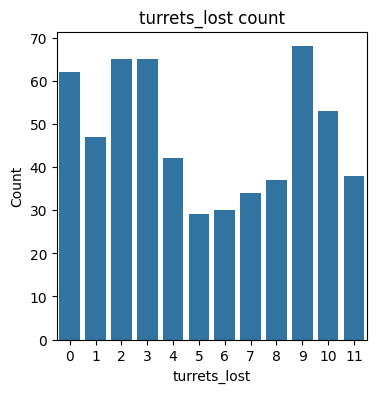

In [33]:
create_bar_plot(df, 'turrets_lost')

Interpretation:
- There is significant spread in the data of turrets lost with the most common outcome being 9

### 2.3.2 Inhibitors lost

In [34]:
gen_info_feat(df, 'inhibitors_lost')

Description:
count    570.000000
mean       0.722807
std        1.013272
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        5.000000
Name: inhibitors_lost, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                 Count  Frequency (%)
inhibitors_lost                      
0                  328      57.543860
1                  124      21.754386
2                   77      13.508772
3                   32       5.614035
4                    7       1.228070
5                    2       0.350877


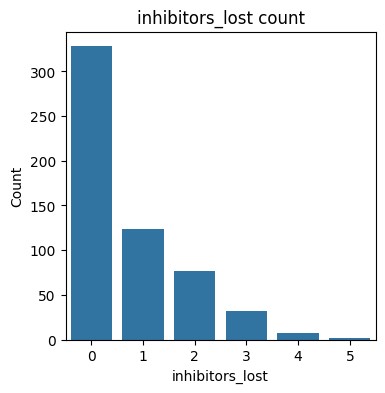

In [35]:
create_bar_plot(df, 'inhibitors_lost')

Interpretation:
- Distribution is right skewed
- Most champions in the data did not lose an inhibitor

### 2.3.3 Nexus lost

In [36]:
gen_info_feat(df, 'nexus_lost')

Description:
count    570.000000
mean       0.326316
std        0.469276
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: nexus_lost, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
            Count  Frequency (%)
nexus_lost                      
0             384      67.368421
1             186      32.631579


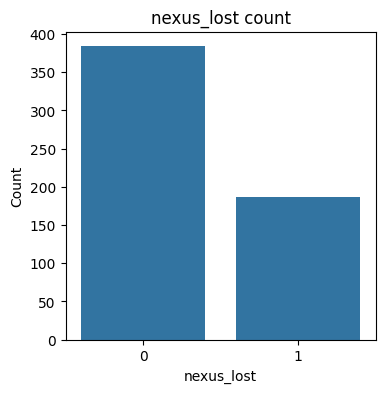

In [37]:
create_bar_plot(df, 'nexus_lost')

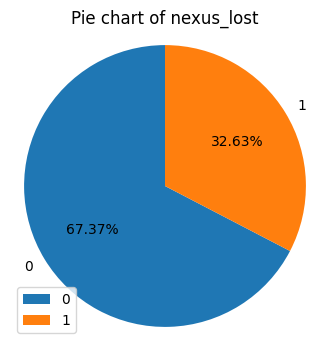

In [38]:
create_pie_plot(df, 'nexus_lost')

Interpretation:
- Only ~32% of the champions lost the their nexus

### 2.3.4 Bounty level

In [39]:
gen_info_feat(df, 'bounty_level')

Description:
count    570.000000
mean       0.938596
std        1.786913
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       13.000000
Name: bounty_level, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
              Count  Frequency (%)
bounty_level                      
0               375      65.789474
1                69      12.105263
2                42       7.368421
3                33       5.789474
4                18       3.157895
5                17       2.982456
7                 5       0.877193
6                 5       0.877193
13                2       0.350877
8                 2       0.350877
10                1       0.175439
9                 1       0.175439


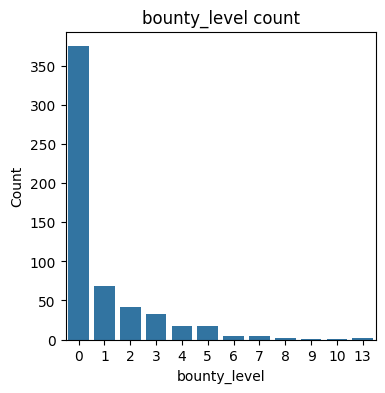

In [40]:
create_bar_plot(df, 'bounty_level')

Interpretation:
- Distribution is heavily skewed right
- A small percentage of the champions actually achieved a bounty

### 2.3.5 Turret takedowns

In [41]:
gen_info_feat(df, 'turret_takedowns')

Description:
count    570.000000
mean       2.238596
std        2.087519
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       10.000000
Name: turret_takedowns, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                  Count  Frequency (%)
turret_takedowns                      
0                   139      24.385965
1                   122      21.403509
2                    93      16.315789
3                    71      12.456140
4                    61      10.701754
5                    34       5.964912
6                    25       4.385965
7                    13       2.280702
8                    10       1.754386
10                    2       0.350877


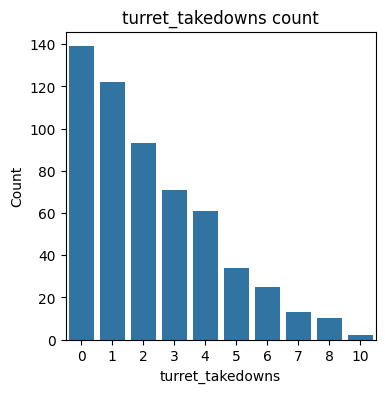

In [42]:
create_bar_plot(df, 'turret_takedowns')

Interpretation:
- Distribution is right-skewed
- Most champions took down at least one turret

### 2.3.6 Damage dealt to buildings

In [43]:
gen_info_feat(df, 'damage_dealt_to_buildings')

Description:
count      570.000000
mean      4956.482456
std       4362.515845
min          0.000000
25%       1665.750000
50%       3620.000000
75%       7293.000000
max      22644.000000
Name: damage_dealt_to_buildings, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                           Count  Frequency (%)
damage_dealt_to_buildings                      
0                             42       7.368421
2240                           2       0.350877
5779                           2       0.350877
8488                           2       0.350877
2475                           2       0.350877
...                          ...            ...
7948                           1       0.175439
3287                           1       0.175439
10708                          1       0.175439
3376                           1       0.175439
2787                           1       0.175439

[515

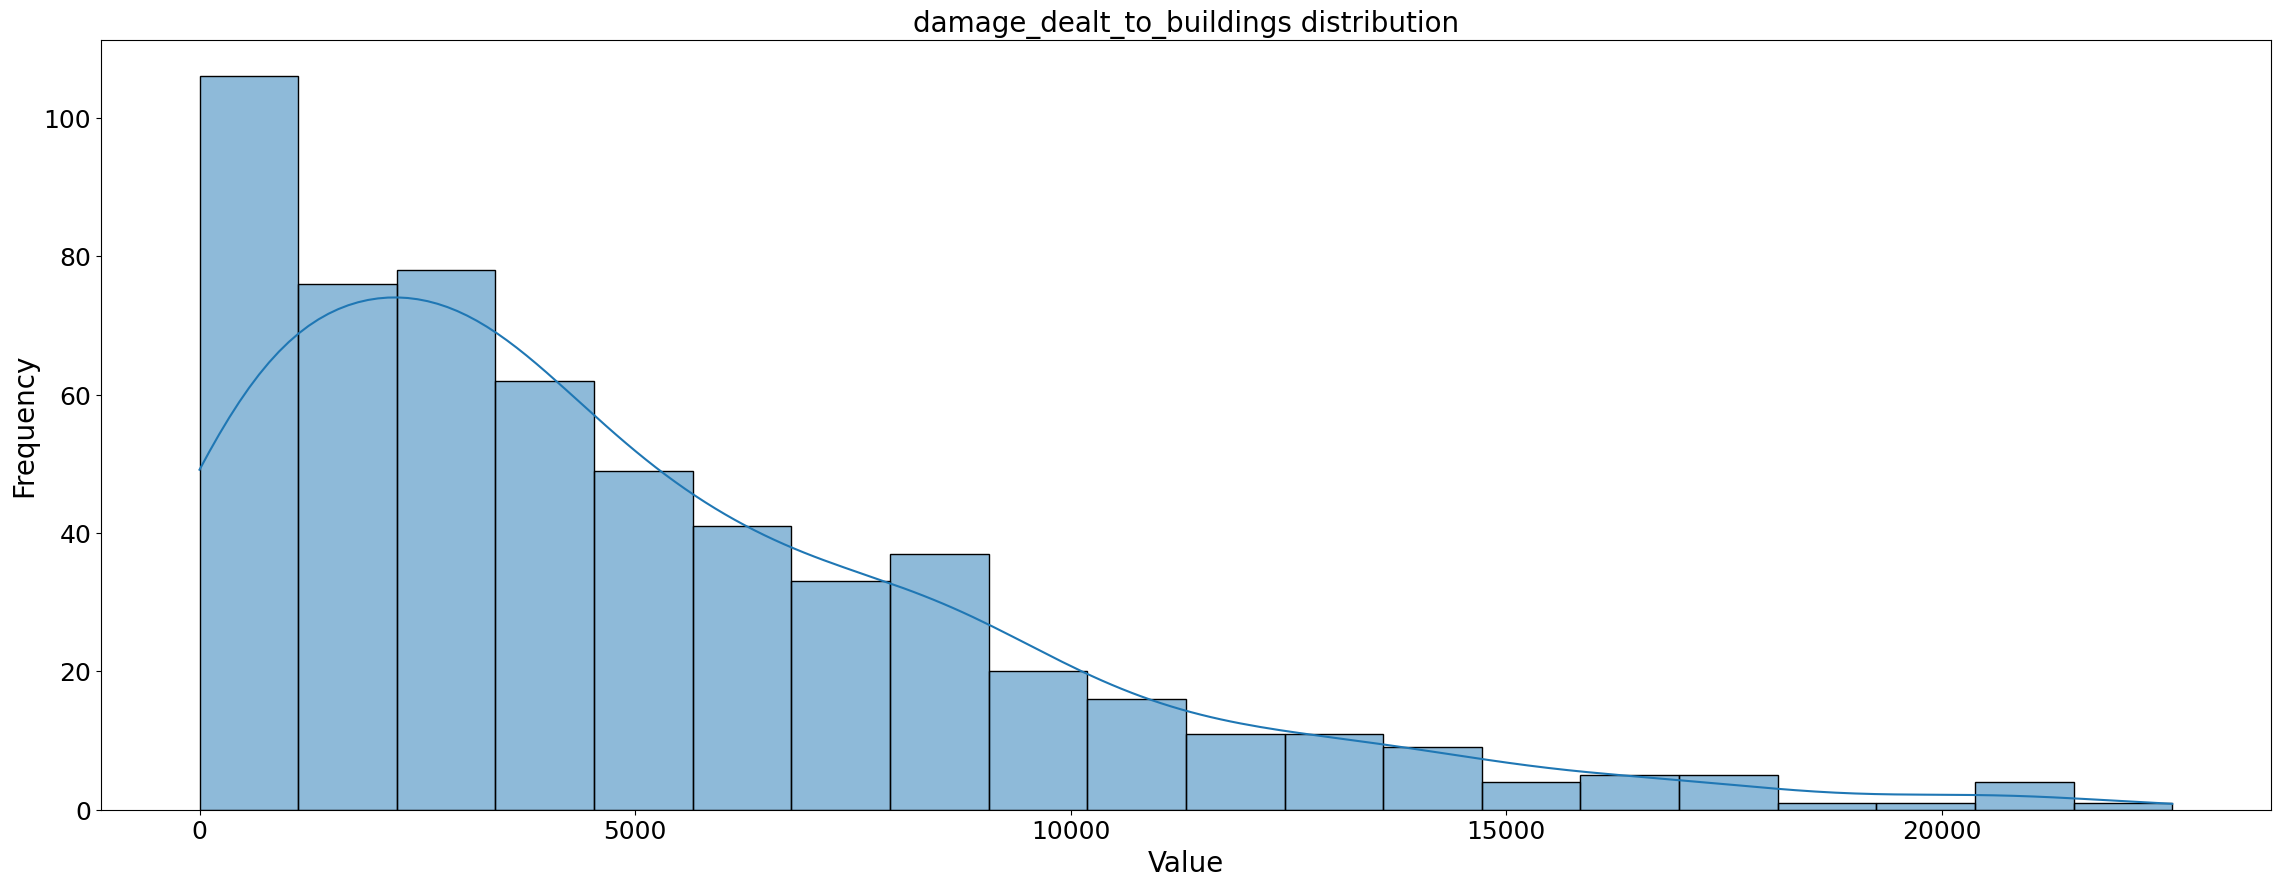

In [44]:
create_hist_plot(df, 'damage_dealt_to_buildings')

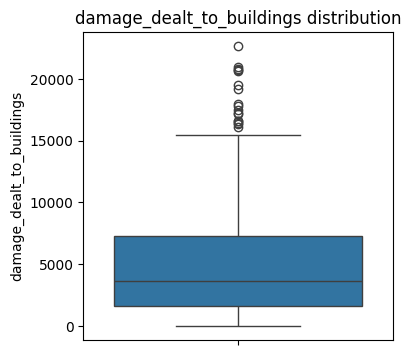

In [45]:
create_box_plot(df, 'damage_dealt_to_buildings')

Interpretation:
- Distribution is right-skewed
- Peak damage distribution is around 2-5k
- Some champions prioritize continued building damage throughout the game

### 2.3.7 Damage dealt to objectives

In [46]:
gen_info_feat(df, 'damage_dealt_to_objectives')

Description:
count      570.000000
mean      7718.487719
std       6793.835767
min          0.000000
25%       2414.750000
50%       5890.500000
75%      11261.750000
max      39680.000000
Name: damage_dealt_to_objectives, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                            Count  Frequency (%)
damage_dealt_to_objectives                      
0                              28       4.912281
14578                           2       0.350877
29578                           2       0.350877
3547                            2       0.350877
15215                           2       0.350877
...                           ...            ...
15639                           1       0.175439
3376                            1       0.175439
1689                            1       0.175439
8040                            1       0.175439
2787                            1       

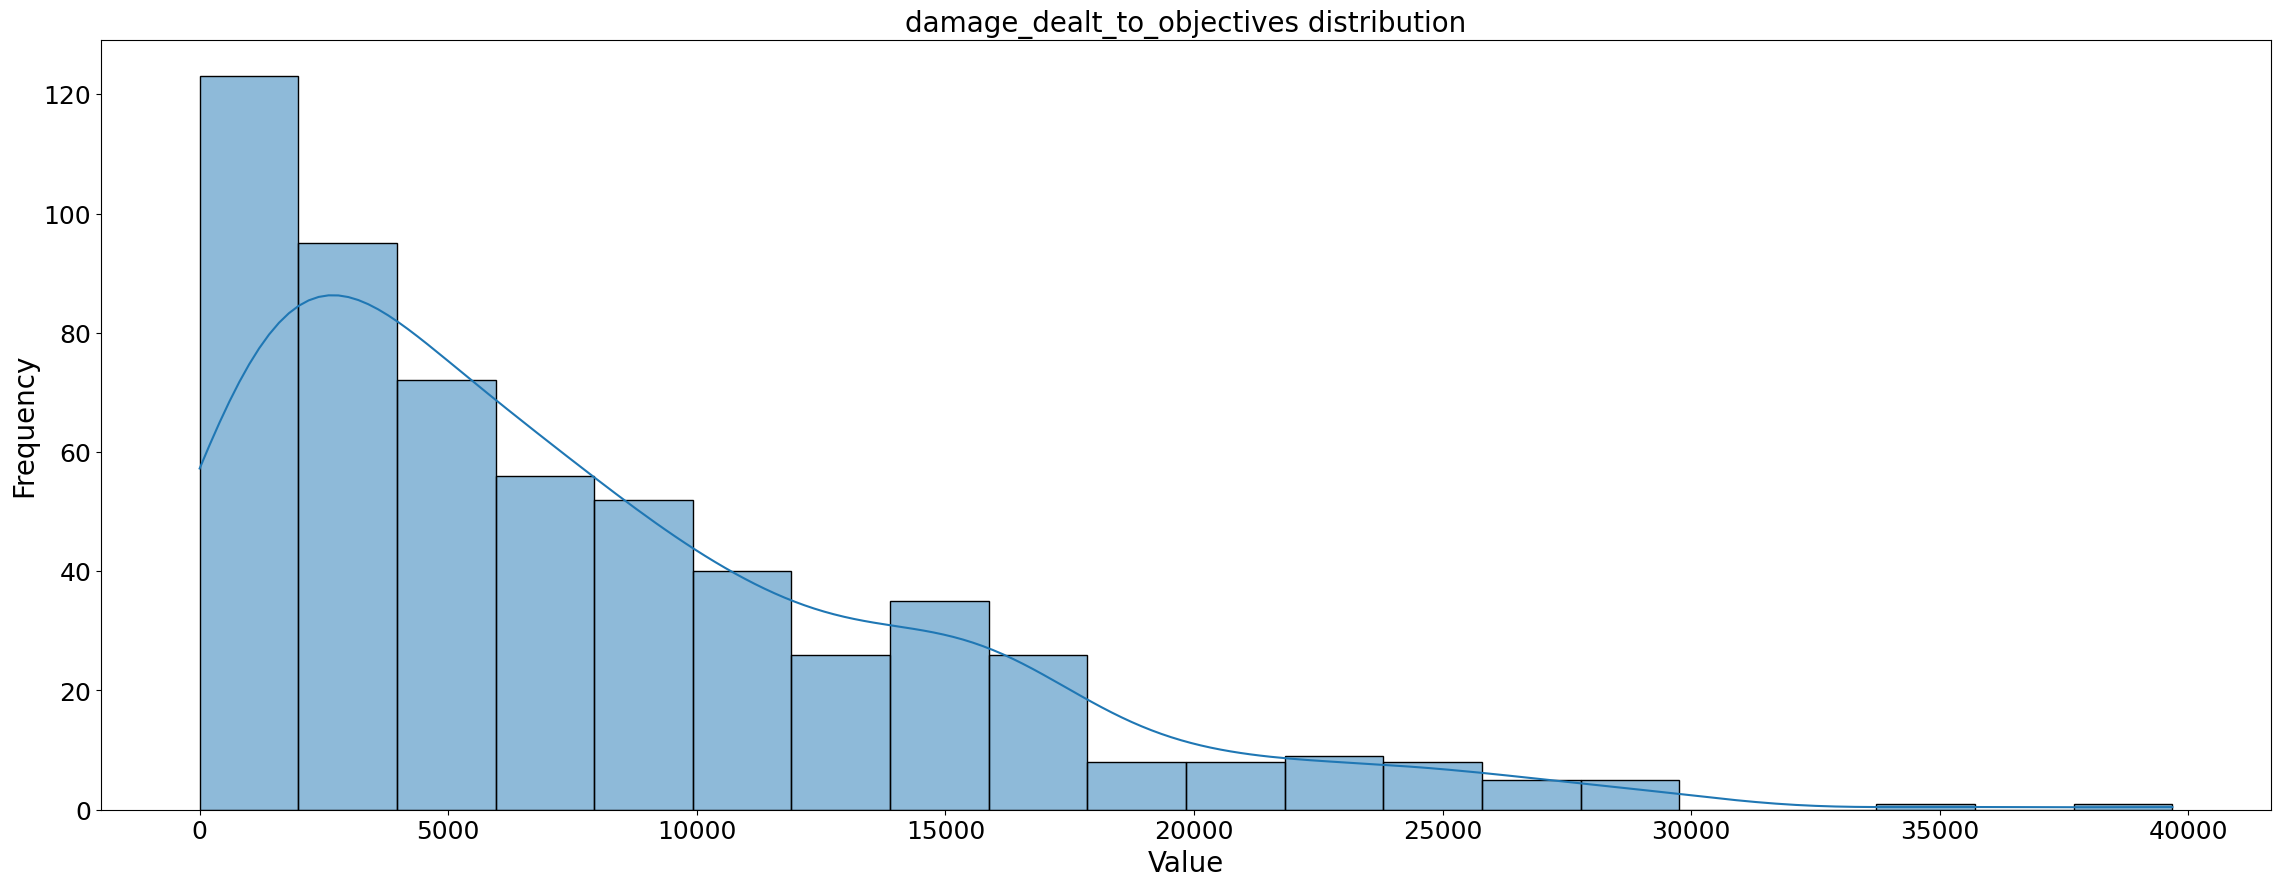

In [47]:
create_hist_plot(df, 'damage_dealt_to_objectives')

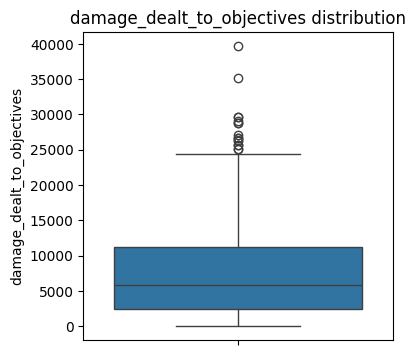

In [48]:
create_box_plot(df, 'damage_dealt_to_objectives')

Interpretation:
- Distribution is right-skewed
- Most champions deal less than 10k damage to objectives, with outliers performning far above the average

### 2.3.8 Inhibitor takedowns

In [49]:
gen_info_feat(df, 'inhibitor_takedowns')

Description:
count    570.000000
mean       0.403509
std        0.695445
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: inhibitor_takedowns, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                     Count  Frequency (%)
inhibitor_takedowns                      
0                      395      69.298246
1                      133      23.333333
2                       30       5.263158
3                       11       1.929825
4                        1       0.175439


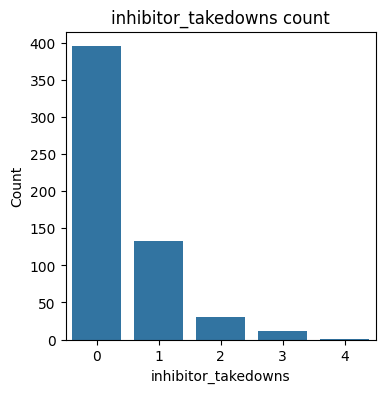

In [50]:
create_bar_plot(df, 'inhibitor_takedowns')

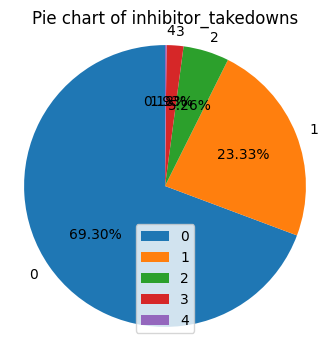

In [51]:
create_pie_plot(df, 'inhibitor_takedowns')

Interpretation:
- Distribution is right-skewed
- Most players in the data don't participate in taking down any inhibitors and leave the responsibility to teammates

### 2.3.9 Assists

In [52]:
gen_info_feat(df, 'assists')

Description:
count    570.000000
mean       5.005263
std        3.886117
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       23.000000
Name: assists, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
         Count  Frequency (%)
assists                      
3           85      14.912281
2           68      11.929825
5           61      10.701754
1           58      10.175439
4           55       9.649123
6           46       8.070175
0           39       6.842105
8           27       4.736842
10          26       4.561404
7           26       4.561404
9           25       4.385965
11          21       3.684211
12          11       1.929825
13           5       0.877193
16           4       0.701754
15           3       0.526316
18           2       0.350877
19           2       0.350877
14           2       0.350877
23           1       0.175439
20 

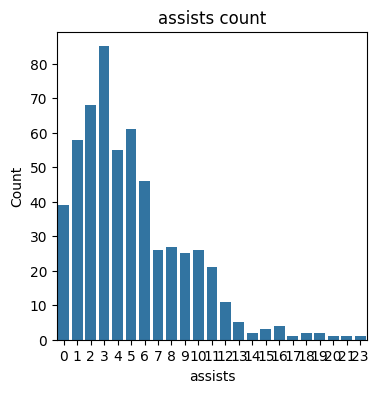

In [53]:
create_bar_plot(df, 'assists')

Interpretation:
- Distribution is right-skewed
- Most assists per game is 3
- High outliers can represent longer-than-average games or high performance

### 2.3.10 Nexus takedowns

In [54]:
gen_info_feat(df, 'nexus_takedowns')

Description:
count    570.000000
mean       0.240351
std        0.427672
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: nexus_takedowns, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                 Count  Frequency (%)
nexus_takedowns                      
0                  433      75.964912
1                  137      24.035088


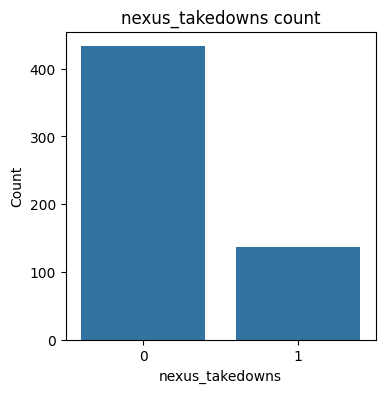

In [55]:
create_bar_plot(df, 'nexus_takedowns')

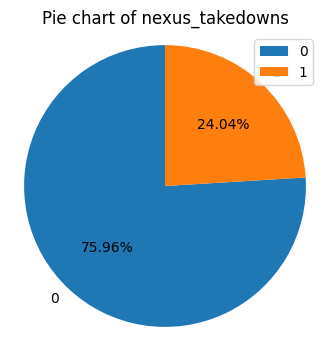

In [56]:
create_pie_plot(df, 'nexus_takedowns')

Interpretation:
- Only ~24% of champions in the data took down the nexus

### 2.3.11 Damage dealt to turrets

In [57]:
gen_info_feat(df, 'damage_dealt_to_turrets')

Description:
count      570.000000
mean      4956.482456
std       4362.515845
min          0.000000
25%       1665.750000
50%       3620.000000
75%       7293.000000
max      22644.000000
Name: damage_dealt_to_turrets, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                         Count  Frequency (%)
damage_dealt_to_turrets                      
0                           42       7.368421
2240                         2       0.350877
5779                         2       0.350877
8488                         2       0.350877
2475                         2       0.350877
...                        ...            ...
7948                         1       0.175439
3287                         1       0.175439
10708                        1       0.175439
3376                         1       0.175439
2787                         1       0.175439

[515 rows x 2 columns]


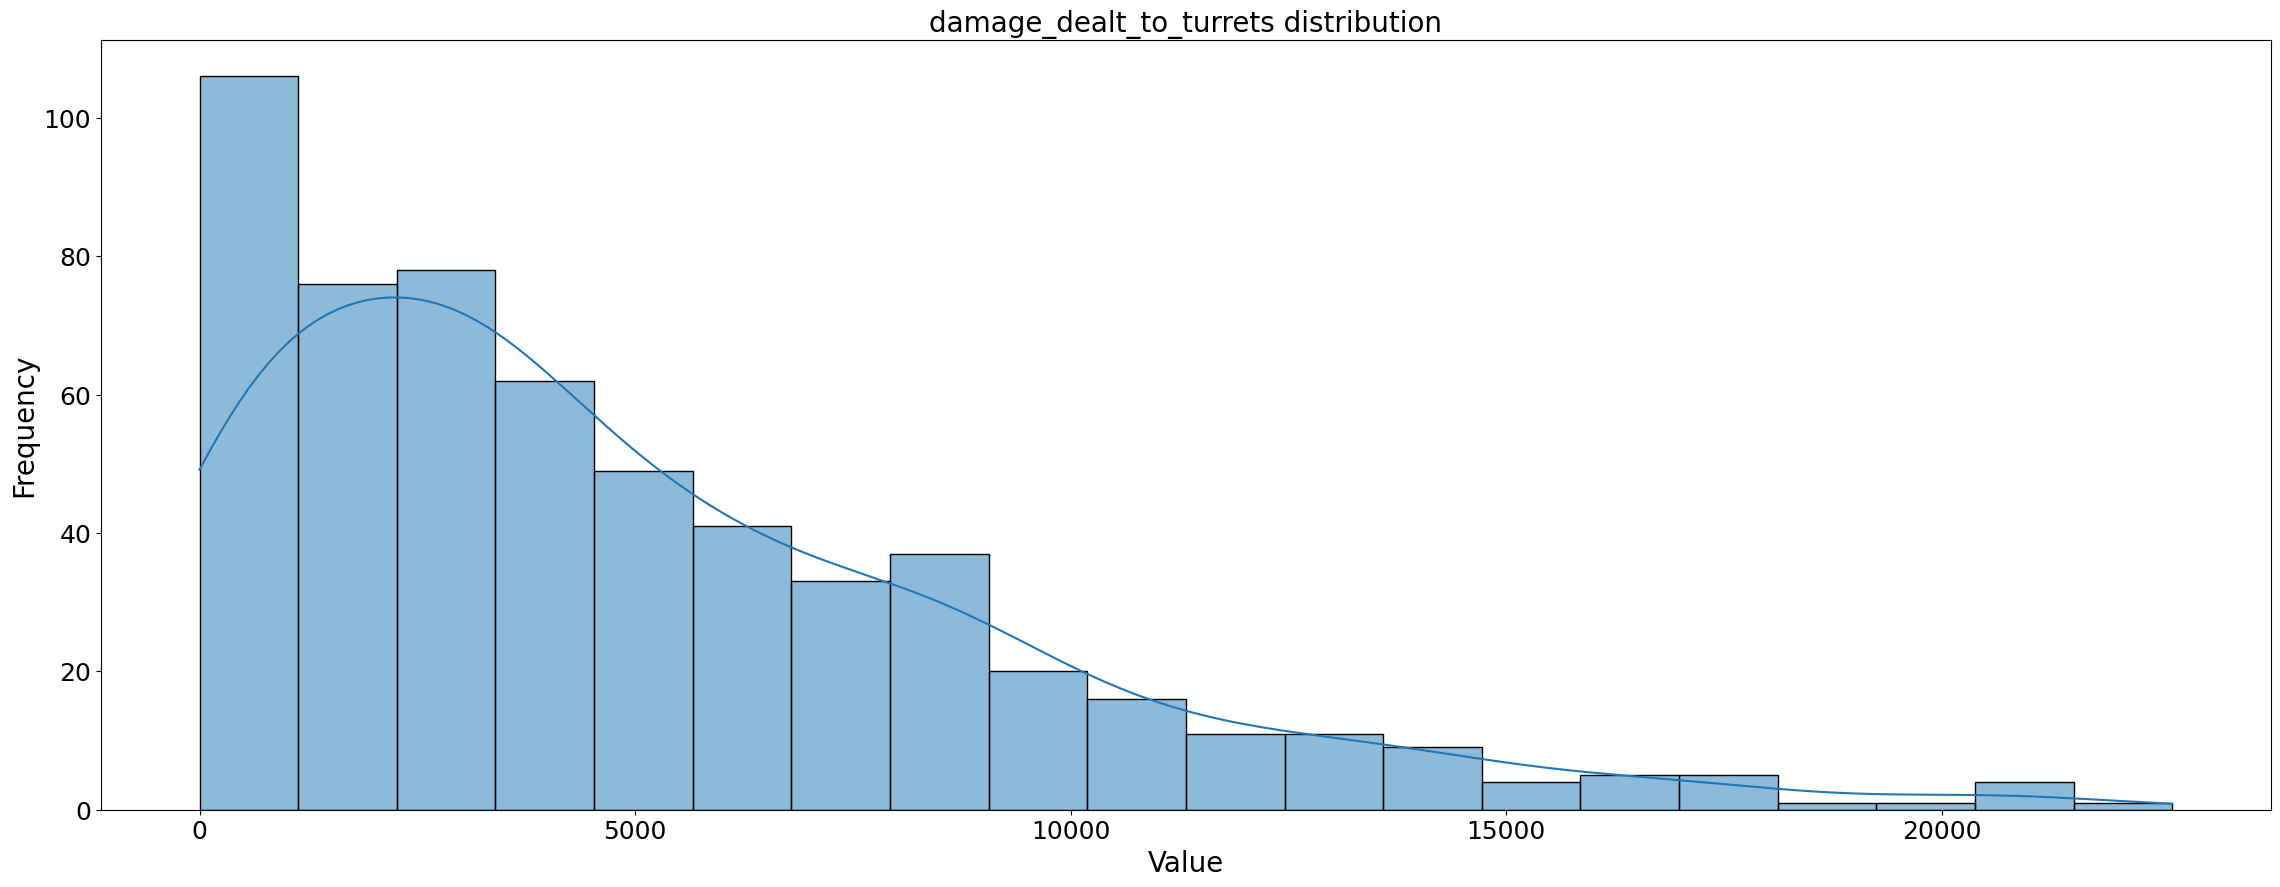

In [58]:
create_hist_plot(df, 'damage_dealt_to_turrets')

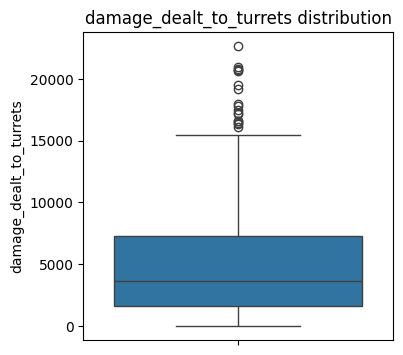

In [59]:
create_box_plot(df, 'damage_dealt_to_turrets')

Interpretation:
- Distribution is slightly right-skewed
- There is a large portion of the data that didn't focus on damage to turrets, while most players dealt between ~2000 - 5000 damage to turrets.

### 2.3.12 Total time spent dead

In [60]:
gen_info_feat(df, 'total_time_spent_dead')

Description:
count    570.000000
mean     155.707018
std       98.236615
min        0.000000
25%       83.250000
50%      141.000000
75%      217.250000
max      581.000000
Name: total_time_spent_dead, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                       Count  Frequency (%)
total_time_spent_dead                      
0                         19       3.333333
48                         7       1.228070
164                        6       1.052632
109                        6       1.052632
129                        6       1.052632
...                      ...            ...
22                         1       0.175439
62                         1       0.175439
298                        1       0.175439
83                         1       0.175439
219                        1       0.175439

[262 rows x 2 columns]


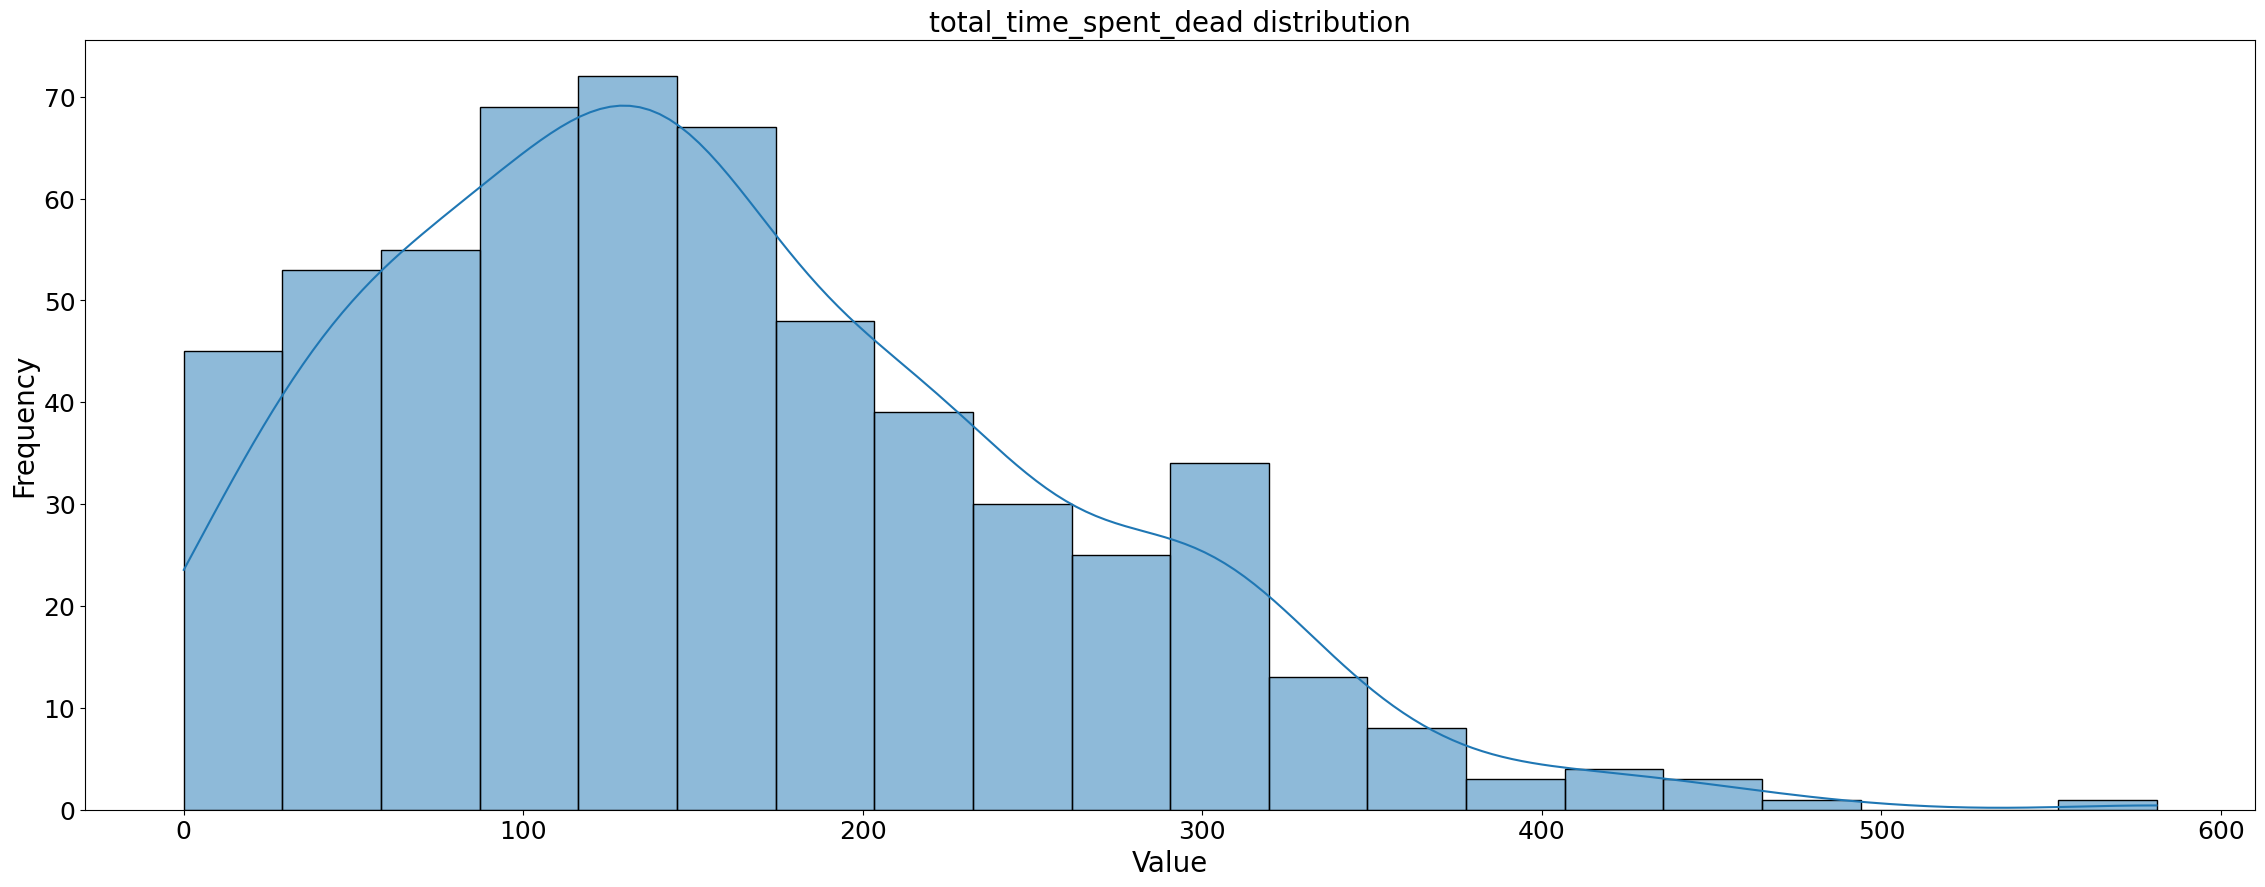

In [61]:
create_hist_plot(df, 'total_time_spent_dead')

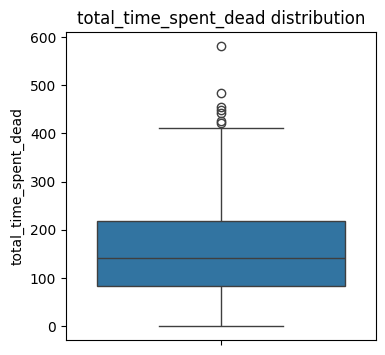

In [62]:
create_box_plot(df, 'total_time_spent_dead')

Interpretation:
- Distribution is right-skewed
- Peak distribution is around 100 seconds spent dead

### 2.3.13 Deaths

In [63]:
gen_info_feat(df, 'deaths')

Description:
count    570.000000
mean       5.192982
std        2.875499
min        0.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       15.000000
Name: deaths, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
        Count  Frequency (%)
deaths                      
5          92      16.140351
4          73      12.807018
6          64      11.228070
3          63      11.052632
2          49       8.596491
7          49       8.596491
8          42       7.368421
1          40       7.017544
9          38       6.666667
10         20       3.508772
0          17       2.982456
12          9       1.578947
11          8       1.403509
13          5       0.877193
15          1       0.175439


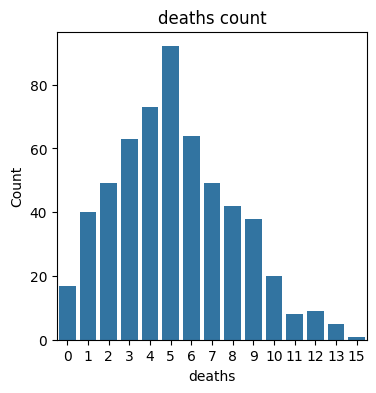

In [64]:
create_bar_plot(df, 'deaths')

Interpretation:
- Distribution is slightly right-skewed
- Most common death amount is 5
- Few cases where champions finished the game with zero deaths which could show exceptional gameplay or highly defensive playstyles

### 2.3.14 Champion experience

In [65]:
gen_info_feat(df, 'champ_experience')

Description:
count      570.000000
mean     13538.492982
std       4214.795052
min          0.000000
25%      10742.500000
50%      13559.000000
75%      16253.750000
max      24376.000000
Name: champ_experience, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                  Count  Frequency (%)
champ_experience                      
0                     6       1.052632
11727                 2       0.350877
23857                 2       0.350877
15957                 2       0.350877
11340                 2       0.350877
...                 ...            ...
8164                  1       0.175439
17913                 1       0.175439
16804                 1       0.175439
14015                 1       0.175439
9783                  1       0.175439

[551 rows x 2 columns]


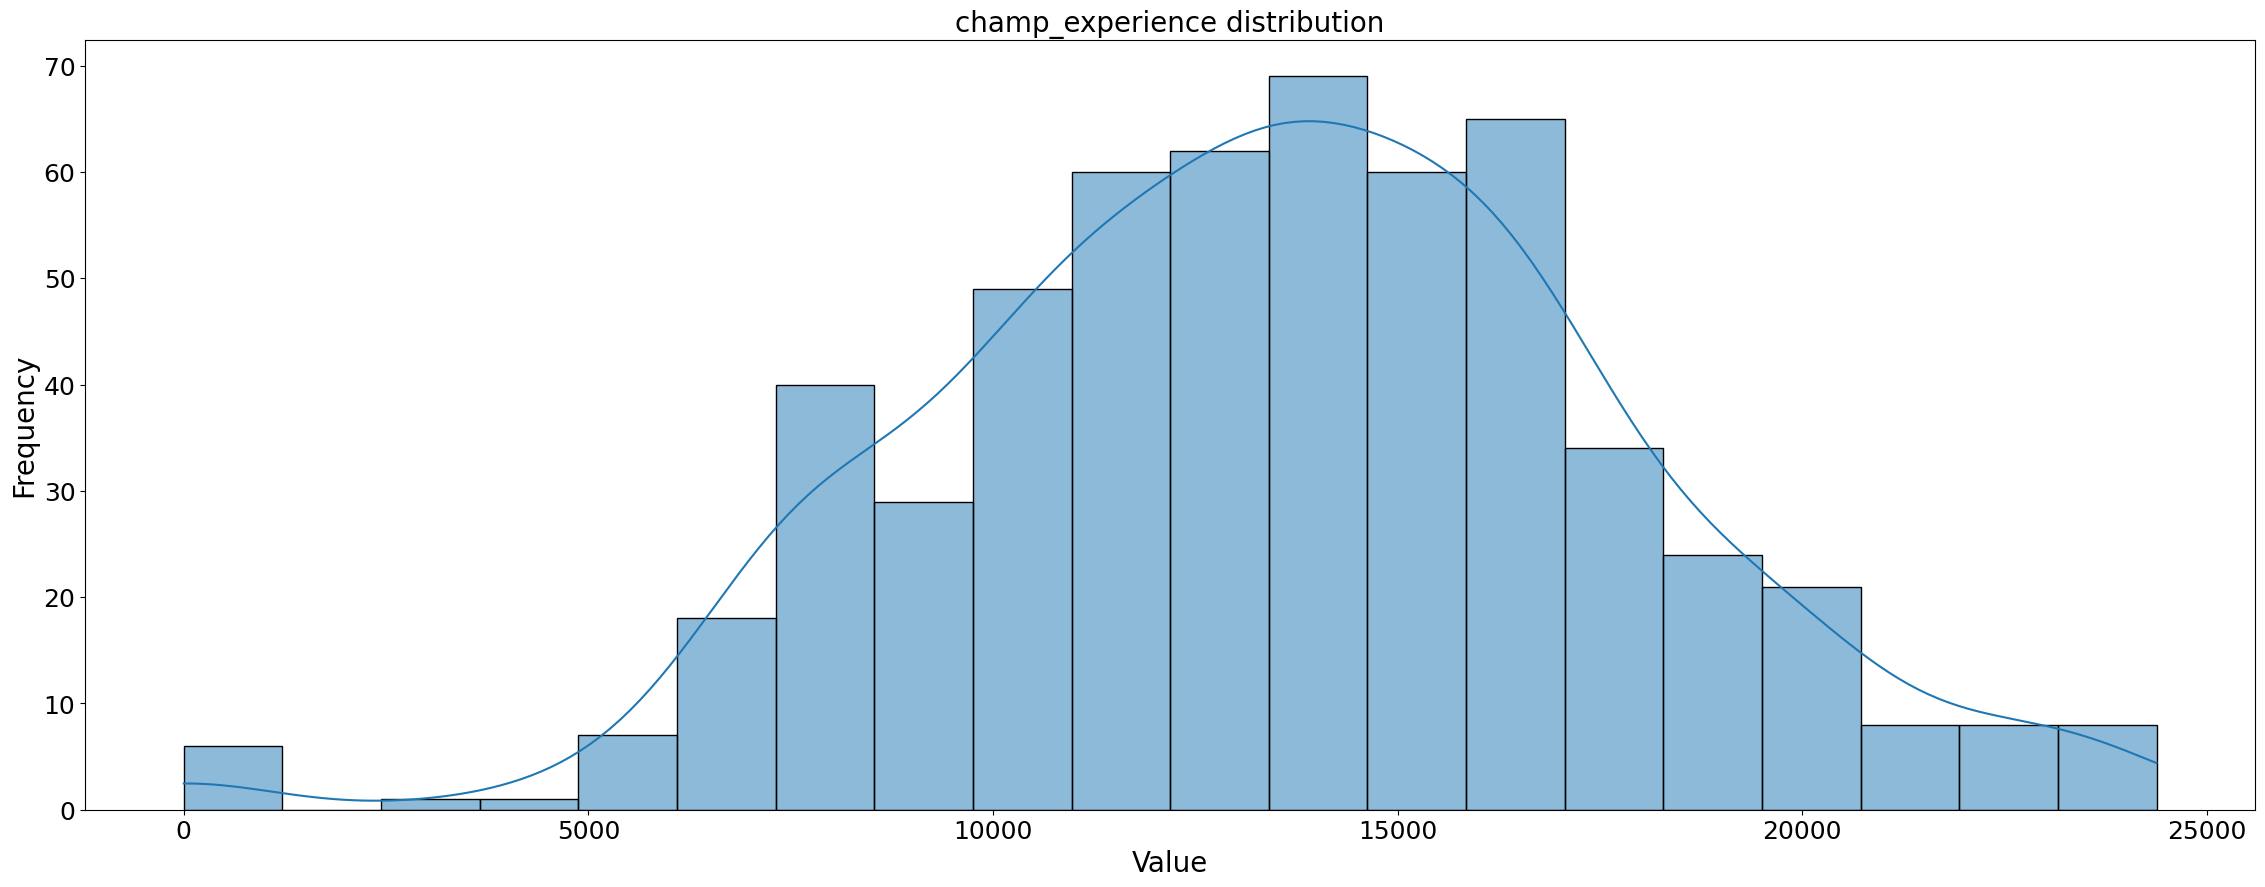

In [66]:
create_hist_plot(df, 'champ_experience')

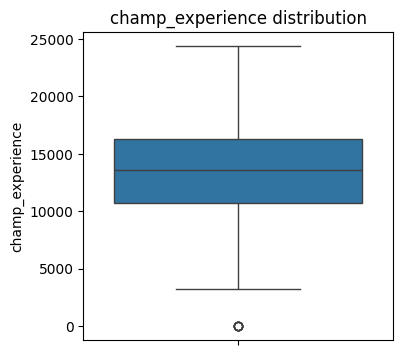

In [67]:
create_box_plot(df, 'champ_experience')

Interpretation:
- Distribution is slightly right-skewed
- Peak distribution is around 12-14k
- Few cases that are sub 5k which could represent early surrenders

### 2.3.15 Gold earned

In [68]:
gen_info_feat(df, 'gold_earned')

Description:
count      570.000000
mean     10888.991228
std       3646.129664
min        500.000000
25%       8571.250000
50%      10849.000000
75%      13372.000000
max      25837.000000
Name: gold_earned, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
             Count  Frequency (%)
gold_earned                      
500              6       1.052632
9696             2       0.350877
10118            2       0.350877
8993             2       0.350877
9907             2       0.350877
...            ...            ...
11487            1       0.175439
13013            1       0.175439
15175            1       0.175439
9213             1       0.175439
7744             1       0.175439

[557 rows x 2 columns]


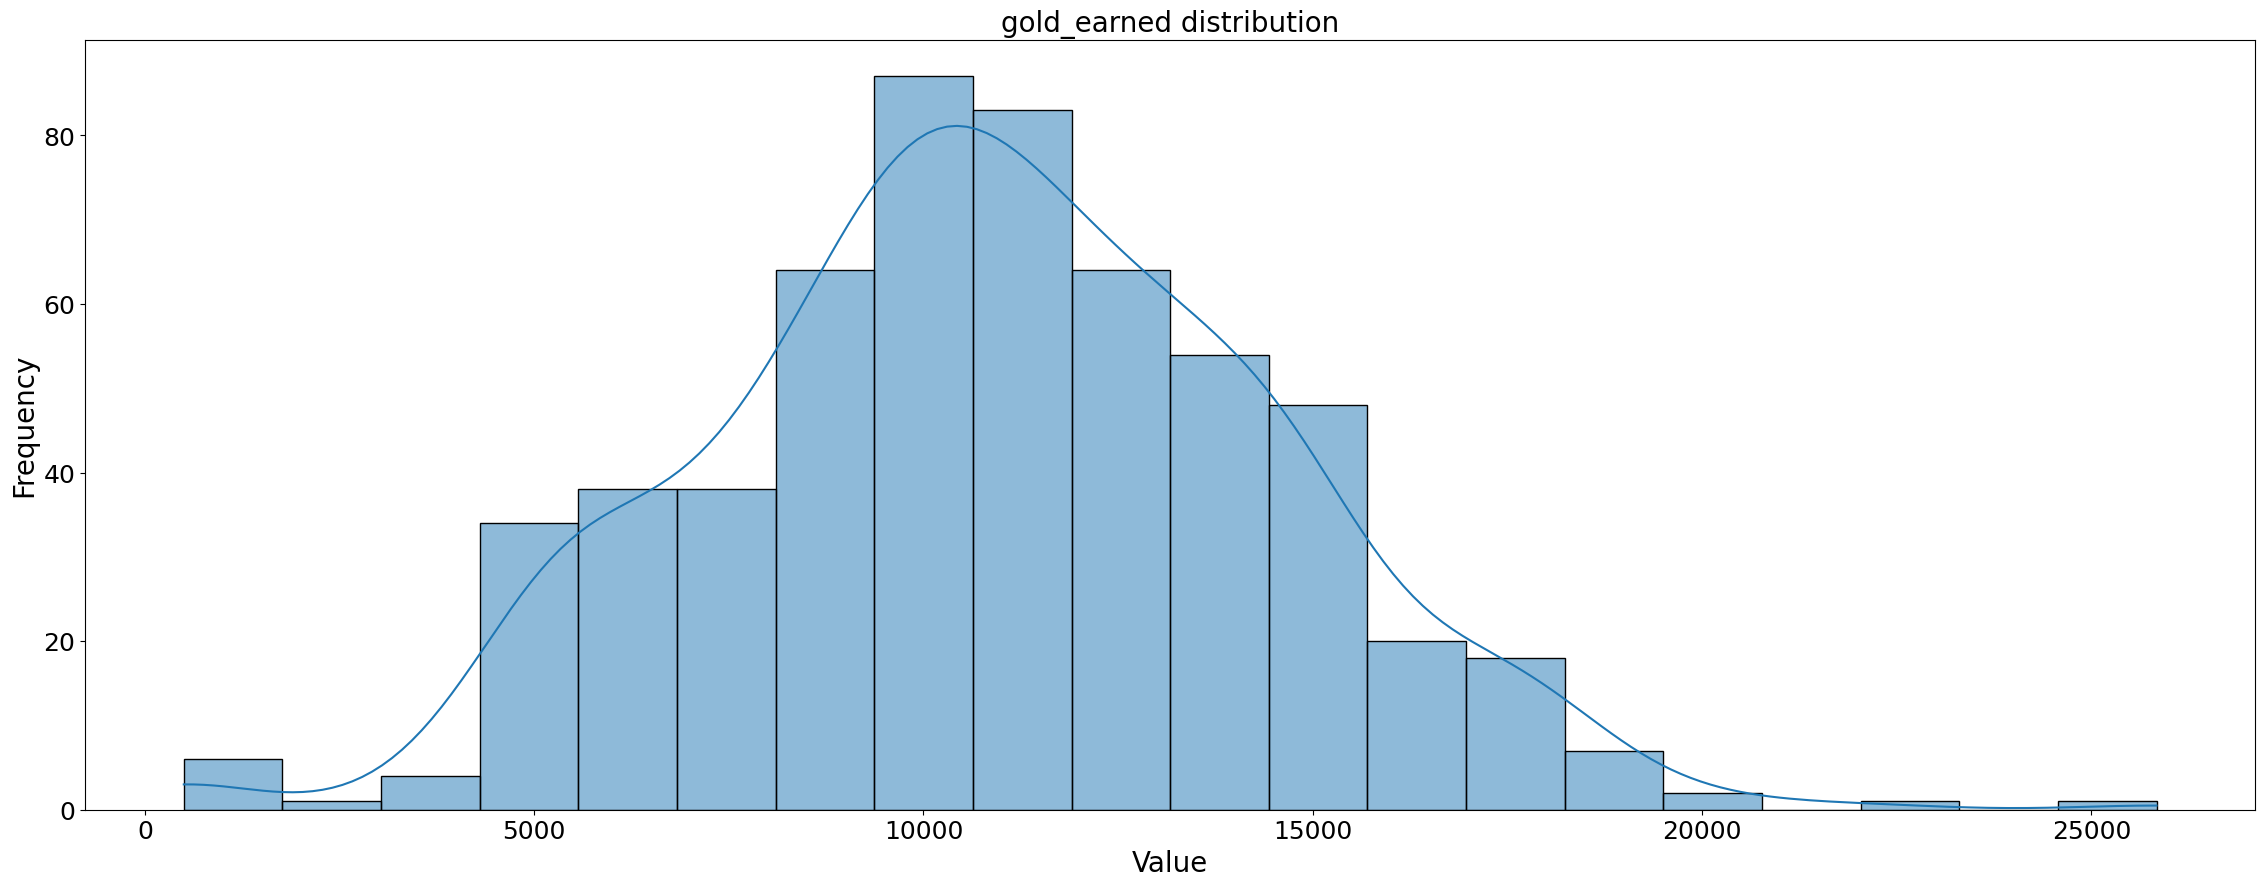

In [69]:
create_hist_plot(df, 'gold_earned')

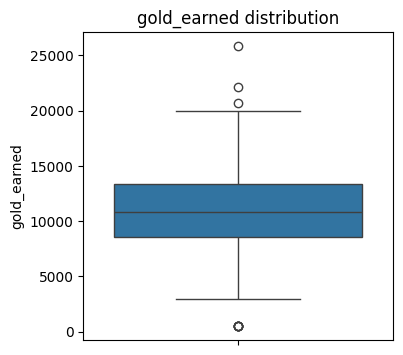

In [70]:
create_box_plot(df, 'gold_earned')

Interpretation:
- Distribution is slightly right-skewed
- Peak distribution is around 10-12k
- Few cases that are sub 5k which could represent early surrenders

### 2.3.16 Wins

In [71]:
gen_info_feat(df, 'win')

Description:
count    570.000000
mean       0.500000
std        0.500439
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: win, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
     Count  Frequency (%)
win                      
0      285           50.0
1      285           50.0


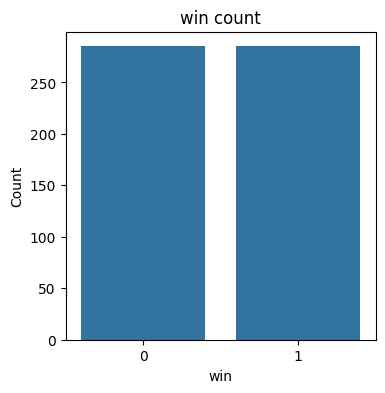

In [72]:
create_bar_plot(df, 'win')

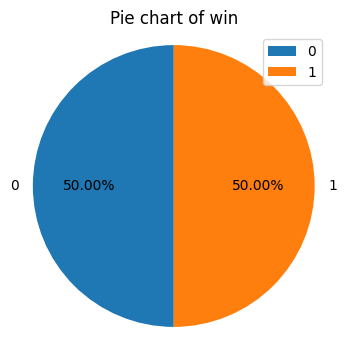

In [73]:
create_pie_plot(df, 'win')

Interpretion:
- Win/loss rate is 50/50

### 2.3.17 Champion name

In [74]:
gen_info_feat(df, 'champion_name')

Description:
count       570
unique       85
top       Garen
freq         26
Name: champion_name, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
               Count  Frequency (%)
champion_name                      
Garen             26       4.561404
Gwen              21       3.684211
Aurora            21       3.684211
Aatrox            20       3.508772
Kennen            20       3.508772
...              ...            ...
Warwick            1       0.175439
Ekko               1       0.175439
Maokai             1       0.175439
Azir               1       0.175439
Belveth            1       0.175439

[85 rows x 2 columns]


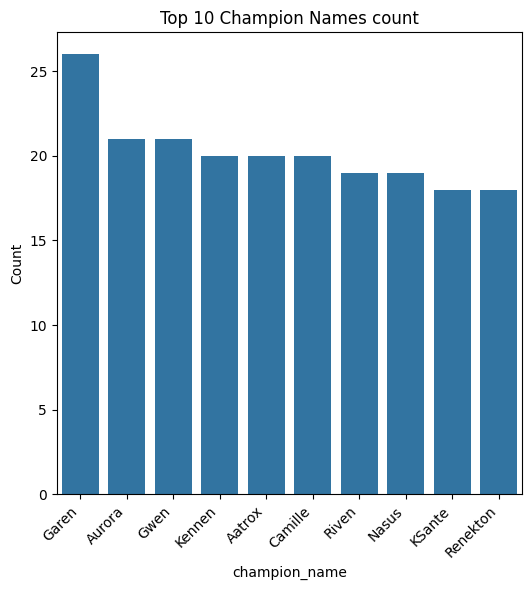

In [75]:
create_bar_plot(df, 'champion_name')

Interpretation:
- Garen leads all champion selections

## 2.4 Bivariate analysis

### 2.4.1 Numerical vs numerical features

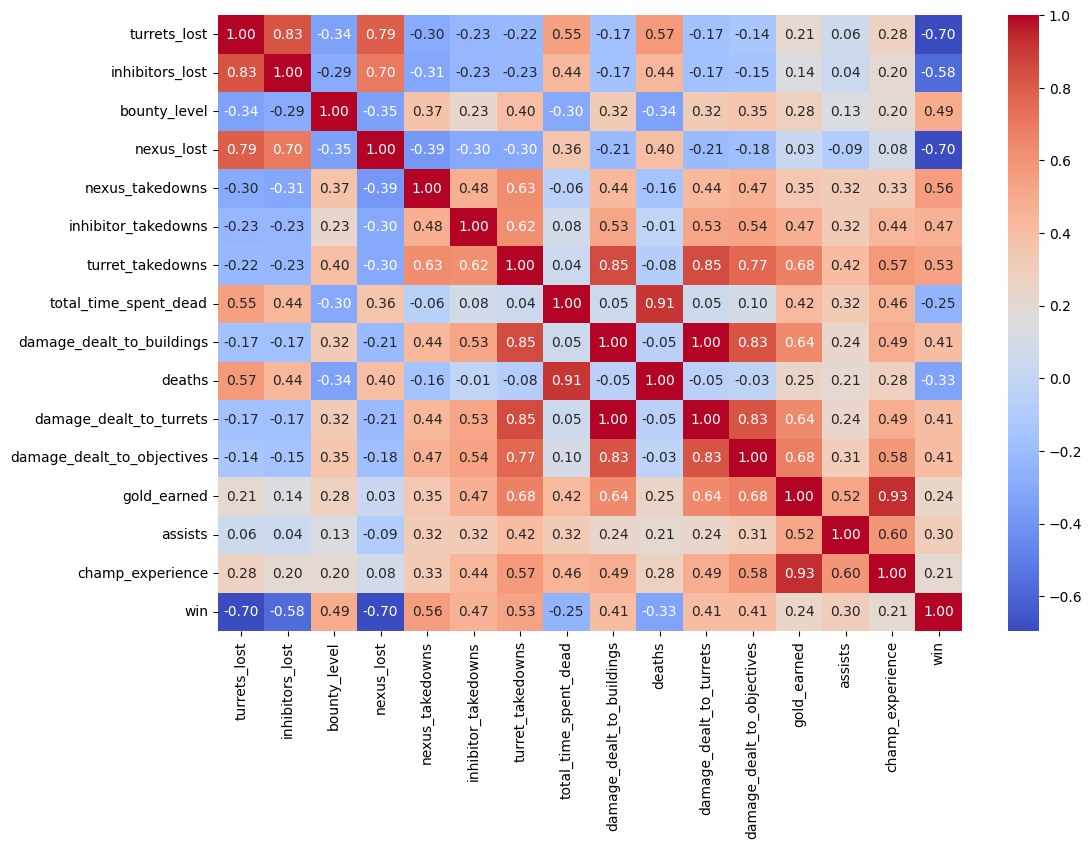

In [76]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes('number').corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Interpretation:
- turrets_lost, inhibitors_lost, nexus_lost have a strong negative correlation with wins due to having such a crucial role in game objectives.
- Turret damage, takedowns, and damage to buildings also have positive correlations with winning
- Bounty level suggests that higher bounties are associated with a higher likelihood of winning

<br>

# 3. Meta analysis

## 3.1 Create performance scores based on important features

### 3.1.1 Calculate match performance score

In [77]:
class CalculateMatchPerformanceScore(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = X.drop(columns=['win', 'champion_name'])
        standardized_features = self.scaler.fit_transform(features)
        performance_score = np.mean(standardized_features, axis=1)
        X['match_performance_score'] = np.round(performance_score, 2)
        X['match_performance_score'] = (X['match_performance_score'] * 100)
        return X

### 3.1.2 Calculate champion performance score

In [78]:
class CalculateChampionPerformance(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        champ_performance = X.groupby('champion_name')['match_performance_score'].mean().reset_index()
        champ_performance.columns = ['champion_name', 'champ_performance_score']
        champ_performance['champ_performance_score'] = champ_performance['champ_performance_score'].round(2)
        X = X.merge(champ_performance, on='champion_name', how='left')
        return X

### 3.1.3 Calculate overall average performance score

In [79]:
class CalculateOverallAverage(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        overall_avg_performance_score = X['match_performance_score'].mean()
        X['overall_avg_performance_score'] = np.round(overall_avg_performance_score, 4)
        return X

### 3.1.4 Assign champions to tier based on performance score

In [80]:
class AssignTiers(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        percentiles = np.percentile(X['champ_performance_score'], [10, 30, 75, 90])
        
        def tier_logic(score):
            if score >= percentiles[3]:
                return 'S-Tier'
            elif score >= percentiles[2]:
                return 'A-Tier'
            elif score >= percentiles[1]:
                return 'B-Tier'
            elif score >= percentiles[0]:
                return 'C-Tier'
            else:
                return 'D-Tier'
        
        X['tier'] = X['champ_performance_score'].apply(tier_logic)
        return X

### 3.1.5 Implement minimum games requirement

In [81]:
class FilterChampionsByGames(BaseEstimator, TransformerMixin):
    def __init__(self, min_games=5):
        self.min_games = min_games
    
    def fit(self, X, y=None):
        # This transformer does not learn anything from the data, so fit simply returns self
        return self
    
    def transform(self, X):
        # Calculate the number of games played by each champion
        games_played = X['champion_name'].value_counts()

        # Filter champions based on the minimum games requirement
        champions_to_keep = games_played[games_played >= self.min_games].index
        filtered_df = X[X['champion_name'].isin(champions_to_keep)]
        
        return filtered_df

### 3.1.6 Create pipeline

In [94]:
# Define the pipeline
performance_pipeline = Pipeline([
    ('calculate_match_performance_score', CalculateMatchPerformanceScore()),
    ('calculate_champ_performance', CalculateChampionPerformance()),
    ('calculate_overall_average', CalculateOverallAverage()),
    ('assign_tiers', AssignTiers()),
    ('filter_champions', FilterChampionsByGames(min_games=5))
])

### 3.1.6 Process data

In [95]:
processed_df = performance_pipeline.fit_transform(df)

### 3.1.7 Save final dataset

In [96]:
# Save dataframe to csv
processed_df.to_csv('champions_tiers.csv', index=False)

## 3.2 Visualizing top lane meta

### 3.2.1 Functions to explore tiers

In [97]:
# Function to plot champions based on tiers
def plot_champion_tiers(df):
    # Count the number of champions in each tier
    tier_counts = df.groupby(['champion_name', 'tier']).size().unstack(fill_value=0)
    
    # Sort by champion name for better visualization
    tier_counts = tier_counts.loc[tier_counts.sum(axis=1).sort_values(ascending=False).index]
    
    # Define colors for each tier
    tier_colors = TIER_COLORS
    
    # Plotting
    tier_counts.plot(kind='bar', stacked=True, color=[tier_colors[tier] for tier in tier_counts.columns], figsize=(14, 8))

    # Adding labels and title
    plt.xlabel('Champion Name')
    plt.ylabel('Number of Games')
    plt.title('Champions by Tier Based on Matches Played')
    plt.xticks(rotation=90)
    plt.legend(title='Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Display the plot
    plt.show()

In [98]:
# Function to plot champions based on performance and tiers
def plot_champion_performance_with_tiers(df):
    # Assuming 'champ_performance_score' and 'tier' are already calculated in the DataFrame
    
    # Calculate the average performance score and associated tier for each champion
    performance_scores = df.groupby(['champion_name', 'tier'])['champ_performance_score'].mean().reset_index()
    
    # Sort by performance score for better visualization
    performance_scores = performance_scores.sort_values(by='champ_performance_score', ascending=False)
    
    # Define colors for each tier
    tier_colors = TIER_COLORS
    
    # Plotting
    plt.figure(figsize=(14, 8))
    bars = plt.barh(performance_scores['champion_name'], 
                    performance_scores['champ_performance_score'], 
                    color=[tier_colors[tier] for tier in performance_scores['tier']])
    
    # Adding labels and title
    plt.xlabel('Average Performance Score')
    plt.ylabel('Champion Name')
    plt.title('Champion Performance Scores with Tiers')
    plt.gca().invert_yaxis()  # To display the highest performance score at the top
    
    # Add a legend manually
    handles = [plt.Rectangle((0,0),1,1, color=tier_colors[tier]) for tier in tier_colors]
    plt.legend(handles, tier_colors.keys(), title="Tier", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

In [99]:
# Function to plot champions based on win rates and tiers
def plot_champion_win_rate_with_tiers(df):
    # Calculate the win rate for each champion
    win_rates = df.groupby(['champion_name', 'tier'])['win'].mean().reset_index()
    win_rates.columns = ['champion_name', 'tier', 'win_rate']
    
    # Sort by win rate for better visualization
    win_rates = win_rates.sort_values(by='win_rate', ascending=False)
    
    # Define colors for each tier
    tier_colors = TIER_COLORS
    
    # Plotting
    plt.figure(figsize=(14, 8))
    bars = plt.barh(win_rates['champion_name'], 
                    win_rates['win_rate'], 
                    color=[tier_colors[tier] for tier in win_rates['tier']])
    
    # Adding labels and title
    plt.xlabel('Win Rate')
    plt.ylabel('Champion Name')
    plt.title('Champion Win Rates with Tiers')
    plt.gca().invert_yaxis()  # To display the highest win rate at the top
    
    # Add a legend manually
    handles = [plt.Rectangle((0,0),1,1, color=tier_colors[tier]) for tier in tier_colors]
    plt.legend(handles, tier_colors.keys(), title="Tier", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

In [100]:
# Function to save visualizations
def save_visualization_to_png(filename, dpi=300):
    # Save the current figure to a PNG file with the specified DPI
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    print(f"Visualization saved as {filename}")

### 3.2.2 Meta visualizations

Visualization saved as champion-performance-scores-tier.png


<Figure size 640x480 with 0 Axes>

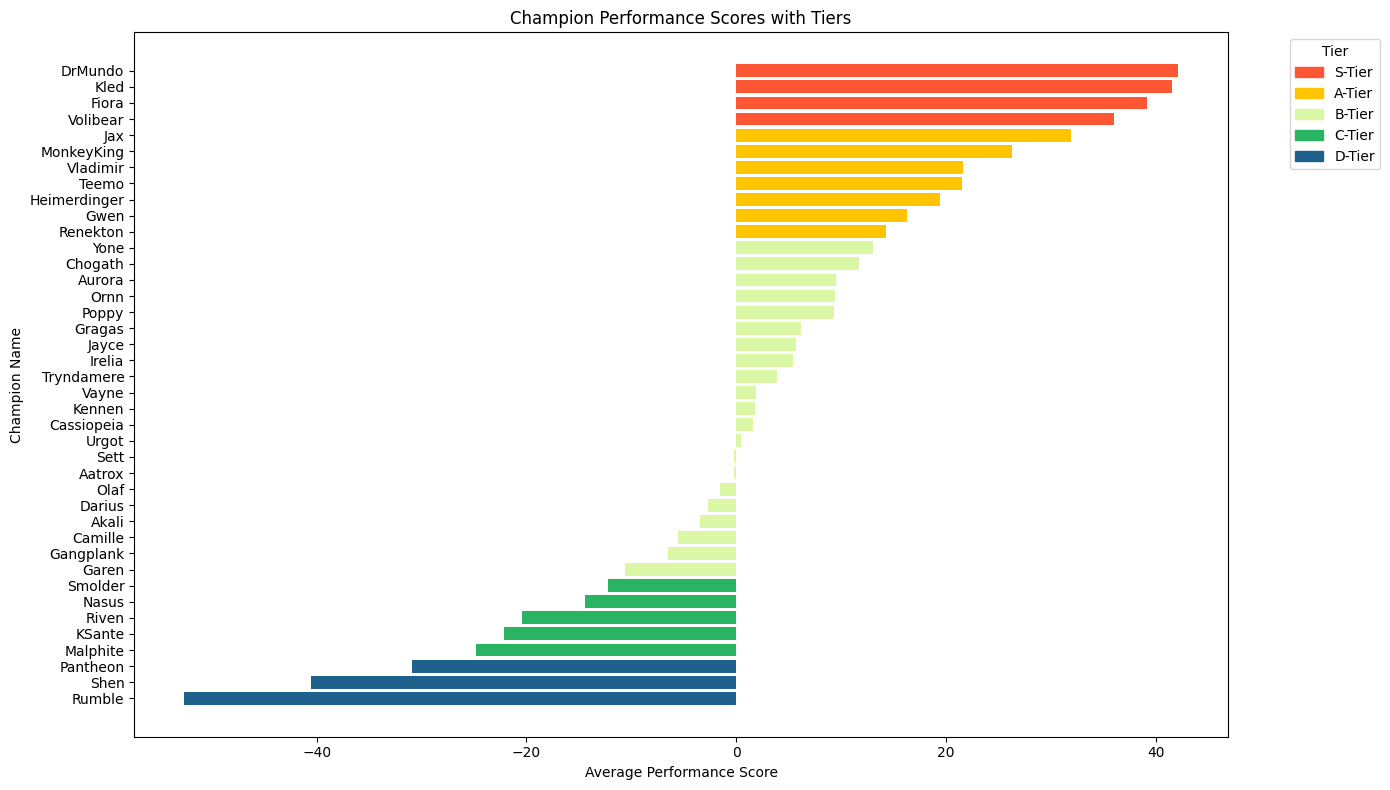

In [101]:
save_visualization_to_png("champion-performance-scores-tier.png")

plot_champion_performance_with_tiers(processed_df)

This plot provides a clear visual representation of how champions are performing on average, with a straightforward way to compare their effectiveness across different tiers.

Interpretation:
- Champions with positive scores are generally performing well, contributing effectively to their games. The higher the score, the better the performance.
- Champions with negative scores are underperforming compared to the rest. This might indicate difficulties in leveraging their full potential or weaknesses in the current meta.
- If you're looking to pick champions with strong performance, those in the S-Tier and A-Tier should be considered top choices based on this analysis.
- Game developers might use this kind of analysis to identify champions that are too strong or too weak and adjust their abilities accordingly in future patches.

Meta Considerations: 
- The presence of several champions in the D-Tier suggests they may be less viable in the current game environment, potentially requiring buffs or strategic adjustments to be effective.

Visualization saved as champion-win-rates-tier.png


<Figure size 640x480 with 0 Axes>

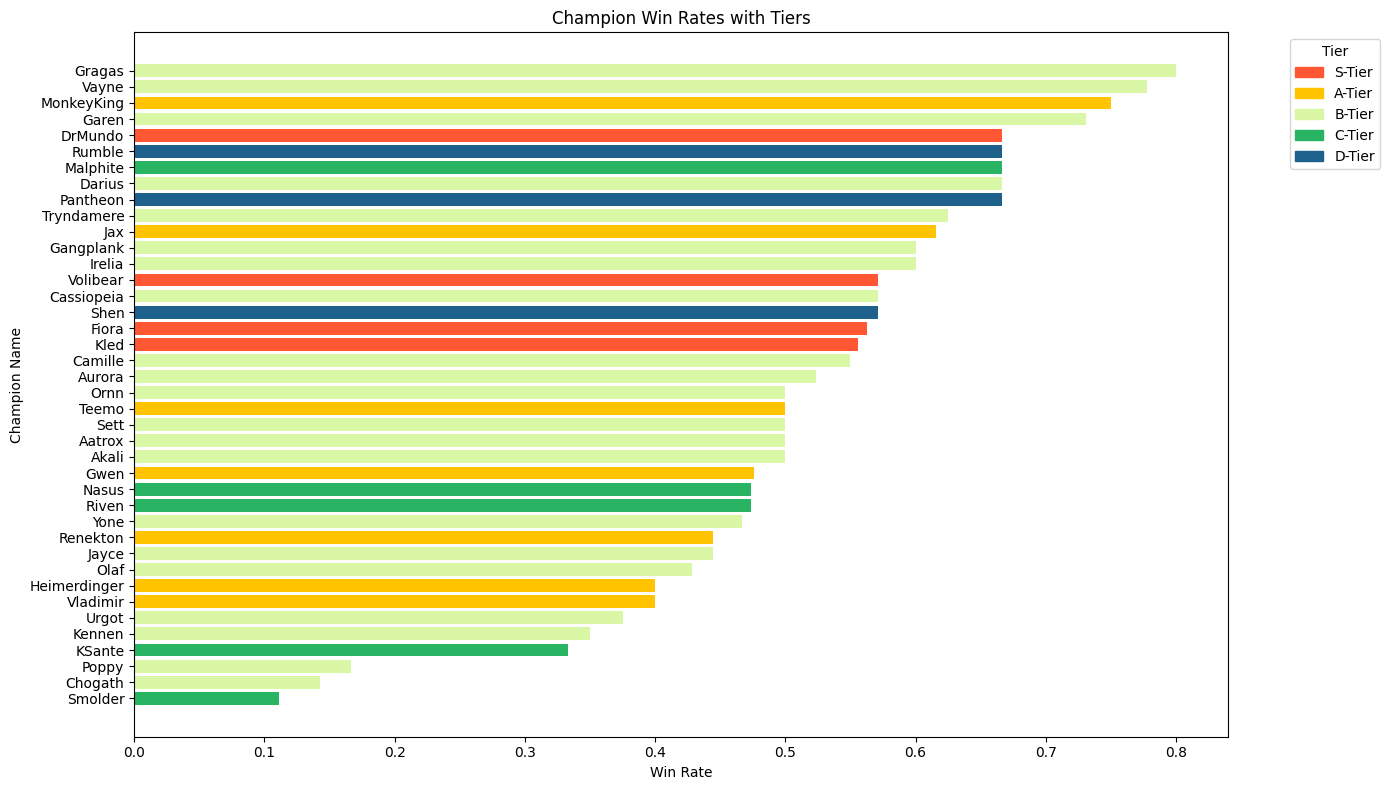

In [102]:
save_visualization_to_png("champion-win-rates-tier.png")

plot_champion_win_rate_with_tiers(processed_df)

This plot provides a detailed view of how champions are performing in terms of win rates, with additional context provided by their tier rankings. It highlights both the strengths of high win rate champions and the complexities of tier rankings in assessing overall champion performance.

Interpretation:
- Champions like Gragas, Monkey King, and Rumble are excellent choices if you prioritize win rate, even if they are not in the highest tier.
- Champions like Dr. Mundo and Monkey King offer a balance of high win rates and top-tier performance, making them solid picks for consistent results.
- Champions with lower win rates like Heimerdinger may require more skill or favorable conditions to succeed, making them riskier picks.
- B-Tier (light-green) and C-Tier (green) dominate the plot, with champions spread across a wide range of win rates. This suggests that while these champions are generally average performers, some can achieve high win rates, potentially due to player skill or favorable matchups.
- S-Tier champions generally have high win rates, reinforcing their status as top performers, but some, like Kled, show that tier rank doesn’t always guarantee the highest win rate.

Meta considerations:
- The plot indicates that win rates do not always correlate directly with tier ranking. Some champions may excel in win rates but still be considered average or below average in the tier system, possibly due to other factors like versatility, consistency, or impact in professional play.

Visualization saved as champion-matches-played-tier.png


<Figure size 640x480 with 0 Axes>

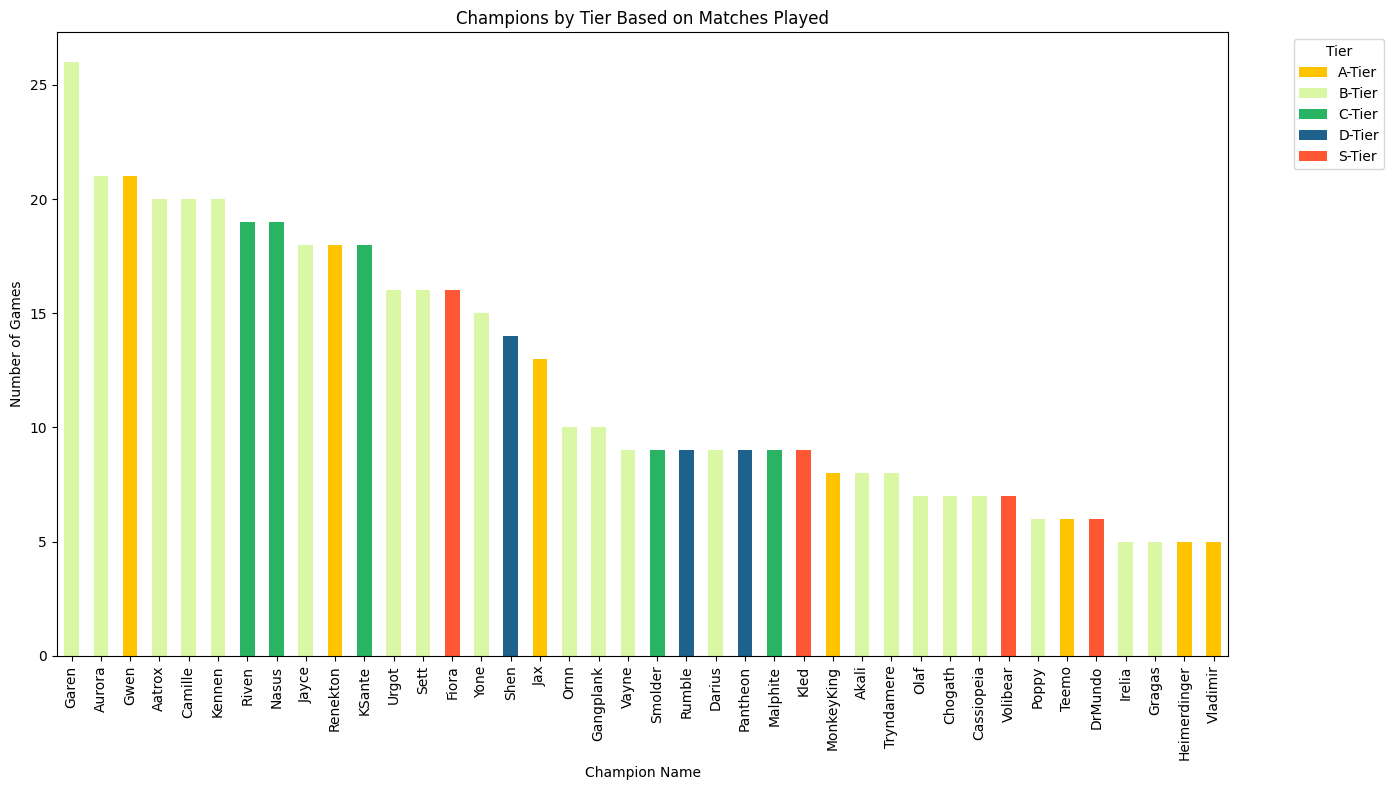

In [104]:
save_visualization_to_png("champion-matches-played-tier.png")

plot_champion_tiers(processed_df)

This plot provides insight into which champions are favored by players, with additional context provided by their tier rankings. It highlights the relationship between a champion's popularity (games played) and their perceived effectiveness (tier).

Interpretation:
- Champions like Garen, Aatrox, and Jayce are popular picks despite being in the B-Tier. This might suggest that these champions are widely used due to their accessibility or popularity, even if their performance is average.
- Fiora and Kled in the S-Tier show that high-tier champions do not always translate to high pick rates, possibly due to their difficulty or specific roles within a team.
- The plot indicates a relatively balanced distribution of game counts across the tiers, with some exceptions. This balance suggests that while certain champions are more popular, there's a wide variety of champions being used by players.

Meta considerations:
- Players looking for champions that are both popular and effective might consider Fiora or Garen, depending on their preferences and playstyle.
- Despite their high play rates, champions like Garen and Riven being in the B/C-Tiers might suggest that these champions are reliable but not necessarily the strongest in terms of win rates or overall effectiveness.

<br>

# 4. Final recommendations

Based on the visualizations, dataset analysis, and meta-analysis, several key recommendations emerge. Firstly, while popular champions such as Garen, Aurora, and Aatrox are frequently chosen by players, their performance as indicated by their tier rankings suggests that they may not be the most effective choices in the current meta. Players should consider the effectiveness of champions like Fiora and Kled, who, despite having lower play rates, demonstrate strong performance and are categorized in higher tiers. This highlights the importance of balancing popularity with performance when selecting champions for competitive play.

Additionally, it is crucial to ensure that analysis is conducted on a robust and sufficiently large dataset. Implementing a minimum game count filter will help exclude outliers and provide more accurate insights into champion performance. The tier-based visualizations provide valuable context by clearly showing the relationship between champion performance and player preferences, making it easier to identify champions that might be underutilized despite their potential.

For future analyses, it is recommended to continually update the dataset to reflect changes in the game meta, such as patches and balance adjustments. This will ensure that the visualizations and insights remain relevant and actionable. By integrating these visualizations into the decision-making process, players and teams can make more informed choices, optimizing their strategies to align with the most effective champions in the current game environment.

Copyright (c) 2024 Josh Tilton